In [1]:
import pandas as pd
import glob
import os
import re
import datetime
from haversine import haversine, Unit
import metpy
import metpy.constants as mpconst
import metpy.units as units
from scipy.interpolate import interp1d
from scipy.optimize import bisect
import numpy as np
import pickle
import numpy as np
import math
import pint
import xarray as xr
import netCDF4 as nc
import re
import matplotlib.pyplot as plt
from numpy import load
from numpy import asarray
from numpy import save
import pytz
from scipy import stats
from sklearn.linear_model import LinearRegression
from collections import Counter
import pymannkendall as mk
from pydoc import help
%matplotlib inline

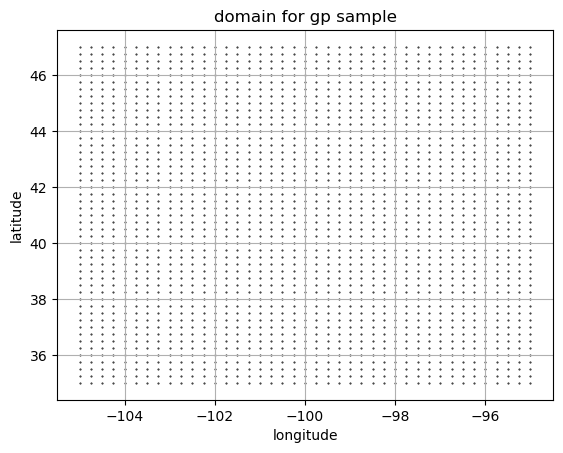

In [8]:
gp = xr.open_dataset('gp_era5_2012.nc')

lat_lon_pairs = []

lat = gp['latitude'].data

lon = gp['longitude'].data

for i in lat:
    
    for j in lon:
        
        p = (i, j)
        
        lat_lon_pairs.append(p)
        
x, y = zip(*lat_lon_pairs)

plt.scatter(y, x, color='black', s=0.2)



plt.grid()

plt.xlabel("longitude")

plt.ylabel("latitude")

plt.title("domain for gp sample")

plt.show()

In [93]:
#average uq east & west across full domain

scale = (24)*(3600)*(1000)

levels_idx = gp['level'].data.shape[0]

levels = gp['level'].data*100

east_lon = -1

west_lon = 0

west_point = (np.mean(gp['latitude'].data), gp['longitude'].data[0])

east_point = (np.mean(gp['latitude'].data), gp['longitude'].data[-1])

dx = haversine(west_point, east_point, unit ='m')

all_lats = gp['latitude'].data.shape[0]

all_months = gp['time'].data.shape[0]

final = []

hov = []

for month in range(all_months):
    
    qu_west_total = []

    qu_east_total = []

    for lat in range(all_lats):

        qu_west = []

        qu_east = []

        for lev in range(levels_idx): 

            q_east = gp['q'].data[month, lev , lat, east_lon]

            u_east = gp['u'].data[month, lev, lat, east_lon]

            q_west = gp['q'].data[month, lev, lat, west_lon]

            u_west = gp['u'].data[month, lev, lat, west_lon]

            qu_east.append(q_east*u_east)

            qu_west.append(q_west*u_west)

        qu_west_total.append(qu_west)

        qu_east_total.append(qu_east)

    qu_east_total_array = [np.array(sublist) for sublist in qu_east_total]

    qu_west_total_array = [np.array(sublist) for sublist in qu_west_total]

    stacked_east_u = np.stack(qu_east_total_array)

    stacked_west_u = np.stack(qu_west_total_array)

    qu_east_mean = np.mean(stacked_east_u, axis=0)

    qu_west_mean = np.mean(stacked_west_u, axis=0)

    qu_profile_diff = qu_east_mean - qu_west_mean

    # plt.plot(qu_profile_diff,levels, label='diff')

    # plt.plot(qu_east_mean, levels, label='east')

    # plt.plot(qu_west_mean, levels, label='west')

    # plt.grid()

    # plt.legend()

    # #integral of mean diff for qu_east and qu_west

    dqu_dx = qu_profile_diff*(1/dx)
    
    to_compare = dqu_dx*scale
    
    tup_hov = (month, to_compare)
    
    hov.append(tup_hov)

    mask = (50 <= levels) & (levels <= 100000)

    dqu_dx_cut = dqu_dx[mask]

    lev_cut = levels[mask]

    _int_u = np.trapz(dqu_dx_cut, lev_cut)

    g = 9.80665 #m/s^2

    rho = 1030 #kg/m^3

    gp_qu = -(_int_u)*(1/g)*(1/rho)*(24)*(3600)*(1000)

    print("month:", gp_qu, "units: mm/day")
    
    tup = (month, gp_qu)
    
    final.append(tup)

month: -1.3488315480649191 units: mm/day
month: -1.7192906634048892 units: mm/day
month: -3.732499719495549 units: mm/day
month: -1.3410939282704062 units: mm/day
month: -3.140681074474239 units: mm/day
month: -2.782371058146342 units: mm/day
month: -5.172092447587817 units: mm/day
month: -1.3329045479814916 units: mm/day
month: -3.271001431767722 units: mm/day
month: -2.859313623895394 units: mm/day
month: -1.5132732210188584 units: mm/day
month: -1.2586098884872905 units: mm/day


In [89]:
# hovdf = pd.DataFrame(hov, columns=['month','advx'])

# months = hovdf['month'].values

# pressure = levels

# for i in [3,6]: 
    
#     advx = hovdf['advx'][i]
    
#     plt.plot(advx, pressure, label=i)
    
# plt.gca().invert_yaxis()
    
# plt.legend()
# plt.grid()

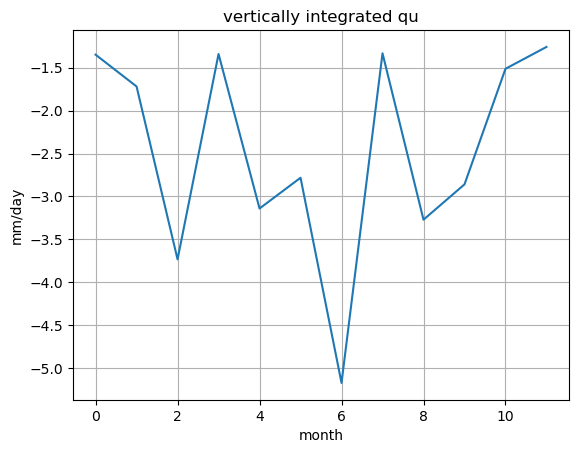

In [49]:
finaldf = pd.DataFrame(final, columns=['month','qu vert'])

plt.plot(finaldf['month'], finaldf['qu vert'])

plt.grid()

plt.ylabel("mm/day")

plt.xlabel("month")

plt.title("vertically integrated qu")

plt.show()